In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [17]:
df_a = pd.read_csv('cohort_a.csv')
df_b = pd.read_csv('cohort_b.csv')
preds = ['intercept', 'age']
targets = ['y1']

Color-code data based on cohort.

Text(0, 0.5, 'y1')

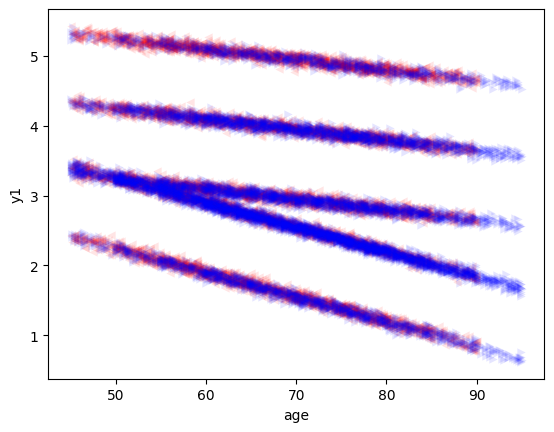

In [18]:
props = dict(lw=0, alpha=0.1)
plt.scatter(df_a['age'], df_a['y1'], c='red', marker='<', label='cohort_a', **props)
plt.scatter(df_b['age'], df_b['y1'], c='blue', marker='>', label='cohort_a', **props)
plt.xlabel('age')
plt.ylabel('y1')

# Concatenate data

In [36]:
df = pd.concat([df_a, df_b])
# Save to a .csv file.
df.to_csv('all_cohorts.csv', index=False)

In [37]:
!head all_cohorts.csv

intercept,age,age^2,id,data_names,traj_gt,y1,y2,cohort
1.0,60.76008111024288,3691.7874565232937,1,1_0,1,5.079434722620619,4.972142760623123,A
1.0,65.76008111024288,4324.388267625723,1,1_1,1,5.001983739786386,4.959629972155811,A
1.0,70.76008111024288,5006.989078728151,1,1_2,1,4.883144142218812,4.90885040244834,A
1.0,79.24696467537123,6280.081410259536,2,2_0,1,4.771473085936481,4.79749532607017,A
1.0,84.24696467537123,7097.551057013248,2,2_1,1,4.835404623367771,4.64375443322302,A
1.0,89.24696467537123,7965.020703766961,2,2_2,1,4.66903943158337,4.699055124943658,A
1.0,78.45622713887482,6155.379576866719,3,3_0,1,4.858145975001487,4.743090837846192,A
1.0,83.45622713887482,6964.9418482554665,3,3_1,1,4.720493878755365,4.761306932020844,A
1.0,88.45622713887482,7824.504119644214,3,3_2,1,4.685448589921943,4.748799226453444,A


# Fit to data

In [61]:
import pickle
with open('prior.p', 'rb') as f:
    prior = pickle.load(f)
print(prior)

{'w_mu0': {'y1': {'intercept': 5.096582388717132, 'age': -0.027422434992009456}}, 'w_var0': {'y1': {'intercept': 1.0, 'age': 5.558852318011903e-05}}, 'lambda_a0': {'y1': 15999999999.999998}, 'lambda_b0': {'y1': 40000000.0}, 'w_mu': None, 'w_var': None, 'lambda_a': None, 'lambda_b': None, 'v_a': None, 'v_b': None, 'traj_probs': None, 'alpha': 0.5}


TODO add a y2 prior and set --targets y1,y2

In [58]:
!bayes_traj_main --in_csv all_cohorts.csv --targets y1 --groupby id --prior prior.p --verbose --iters 4000 --repeats 1 --use_pyro -k 5 --out_model foo_pyro.pt

Reading prior...
Traceback (most recent call last):
  File "/Users/fritzo/miniconda3/envs/copd/bin/bayes_traj_main", line 33, in <module>
    sys.exit(load_entry_point('bayes-traj', 'console_scripts', 'bayes_traj_main')())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/fritzo/github/acil-bwh/bayes_traj/bayes_traj/bayes_traj_main.py", line 182, in main
    prior_data['lambda_a0'][d] = prior_file_info['lambda_a0'][target]
                                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^
KeyError: 'y2'


# Inspect fit

In [43]:
model = torch.load('foo_pyro.pt')

In [44]:
model.alpha0

tensor([100., 100., 100., 100., 100.])

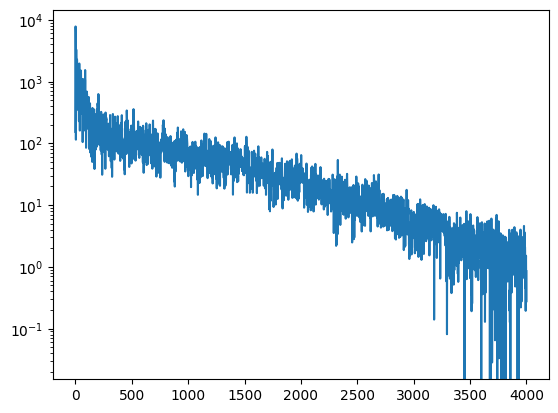

In [45]:
plt.plot(model.losses)
plt.yscale('log')

In [48]:
data = get_restructured_data(df, preds, targets, 'id')
X = data['X']
Y_real = data['Y_real']
Y_real_mask = data['Y_real_mask']

           X: torch.Size([7, 3000, 2])
      X_mask: torch.Size([7, 3000])
      Y_real: torch.Size([7, 3000, 1])
 Y_real_mask: torch.Size([7, 3000])
      Y_bool: n/a
 Y_bool_mask: n/a
      cohort: torch.Size([3000])


In [50]:
probs = model.classify(**data)

In [69]:
print(probs)

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])


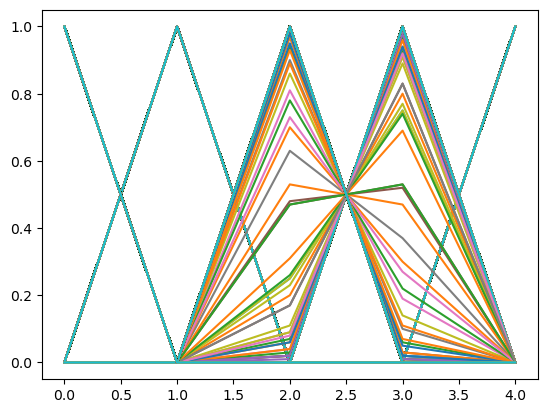

In [70]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

In [51]:
np.sum(probs.numpy(),0)

array([545.17, 399.25, 542.75, 756.  , 756.83])

In [52]:
np.argmax(probs.numpy(), axis=1)

array([1, 1, 1, ..., 3, 3, 3])

In [53]:
df['traj_gt']

0       1
1       1
2       1
3       1
4       1
       ..
9995    5
9996    5
9997    5
9998    5
9999    5
Name: traj_gt, Length: 19000, dtype: int64

In [54]:
model.estimate_params()

{'W_mu': tensor([[[ 4.1162, -0.0176]],
 
         [[ 5.9154, -0.0123]],
 
         [[ 5.0540, -0.0155]],
 
         [[ 4.0176, -0.0364]],
 
         [[ 4.9560, -0.0340]]]),
 'W_var': tensor([[[2.9620e-05, 1.9138e-08]],
 
         [[2.3002e-05, 2.9241e-08]],
 
         [[1.2267e-05, 2.0285e-08]],
 
         [[2.9619e-05, 2.2126e-08]],
 
         [[7.7366e-05, 1.9240e-08]]]),
 'lambda_mu': tensor([[400.0227],
         [399.8925],
         [400.2107],
         [400.1644],
         [399.1694]]),
 'lambda_var': tensor([[0.0002],
         [0.0003],
         [0.0001],
         [0.0085],
         [0.0005]])}

Let's examine the model's predicted distribution over classes, broken down by cohort.

In [57]:
model.guide.median()["class_probs"]

tensor([[0.2025, 0.1946, 0.2007, 0.2029, 0.1992],
        [0.1644, 0.0828, 0.1679, 0.2924, 0.2926]])

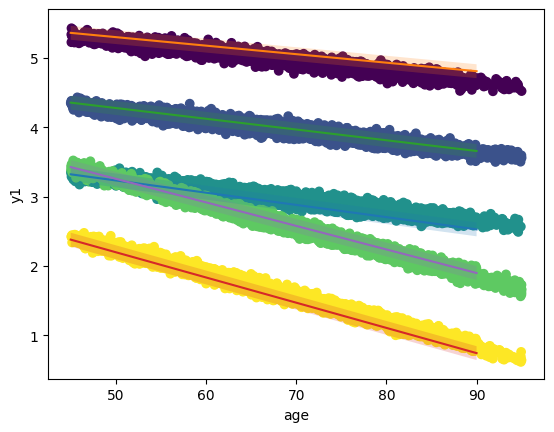

In [55]:
plt.close('all')


plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
#plt.scatter(df['age'], df['y1'], c=np.argmax(probs.numpy(), axis=1))
plt.xlabel('age')
plt.ylabel('y1')

#self.guide.median()

#self.guide() # Dictionary (Draws a sample)

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    #w = model.params['params']['AutoNormal.locs.W_'][kk, 0].data.numpy()
    #(model.estimate_params()['lambda_mu']).rsqrt().numpy()
    #lambda_ = model.params['params']['AutoNormal.locs.lambda_'][kk].data
    stddev = (model.estimate_params()['lambda_mu']).rsqrt().numpy()[kk]
    w = (model.estimate_params()['W_mu']).numpy()[kk,0]
    
    y1_tmp = np.dot(X.numpy(), w.T)
    plt.plot(X[:, 1], y1_tmp)
    lb = y1_tmp - 2*stddev
    ub = y1_tmp + 2*stddev
    plt.fill_between(X[:, 1], lb, ub, alpha=0.2)
plt.show()

In [21]:
1/np.sqrt(lambda_.item())


0.4087097075189758

In [22]:
print(model.params['params'])

{'AutoNormal.locs.class_probs': Parameter containing:
tensor([ 0.1484, -0.0226,  0.0086, -0.2148], requires_grad=True), 'AutoNormal.scales.class_probs': Parameter containing:
tensor([-4.5952, -4.5952, -4.6052, -4.5952], requires_grad=True), 'AutoNormal.locs.W_': Parameter containing:
tensor([[[ 5.2234, -0.0233]],

        [[ 5.4480, -0.0324]],

        [[ 4.3478, -0.0417]],

        [[ 6.4087, -0.0357]],

        [[ 6.2381, -0.0309]]], requires_grad=True), 'AutoNormal.scales.W_': Parameter containing:
tensor([[[-4.5952, -4.5952]],

        [[-4.5952, -4.5952]],

        [[-4.5952, -4.5952]],

        [[-4.5952, -4.6052]],

        [[-4.6052, -4.5952]]], requires_grad=True), 'AutoNormal.locs.lambda_': Parameter containing:
tensor([[5.9865],
        [5.9965],
        [5.9864],
        [5.9965],
        [5.9865]], requires_grad=True), 'AutoNormal.scales.lambda_': Parameter containing:
tensor([[-4.6052],
        [-4.6052],
        [-4.6052],
        [-4.6052],
        [-4.6052]], requires_